In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

In [54]:
df = pd.read_csv('../../datasets/famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 1
target_col = binary_cols[N % 8]
print(f"Target: {target_col}")

Target: interest


In [55]:
selected_features = ['weekend_study', 'bad_sleep', 'glasses', 'anime', 'score', 'sex', 'os', 'work_experience', 'social', 'hostel']
print(selected_features)

['weekend_study', 'bad_sleep', 'glasses', 'anime', 'score', 'sex', 'os', 'work_experience', 'social', 'hostel']


Функция для преобразования данных в числовой формат и преобразование всех столбцов в числовой формат

In [56]:
def convert_to_numeric(df, columns):
    df_converted = df.copy()
    for col in columns:
        if df_converted[col].dtype == 'object':
            unique_vals = df_converted[col].unique()
            mapping = {val: i for i, val in enumerate(unique_vals)}
            df_converted[col] = df_converted[col].map(mapping)
            print(f"{col} mapped to: {mapping}")
    return df_converted

columns_to_convert = selected_features + [target_col]
df_numeric = convert_to_numeric(df, columns_to_convert)

X = df_numeric[selected_features]
y = df_numeric[target_col]

print(f"\n{y.value_counts()}\n")

weekend_study mapped to: {'Да': 0, 'Нет': 1}
bad_sleep mapped to: {'Да': 0, 'Нет': 1}
glasses mapped to: {'Нет': 0, 'Да': 1}
anime mapped to: {'Нет': 0, 'Да': 1}
sex mapped to: {'М': 0, 'Ж': 1}
os mapped to: {'MacOS': 0, 'Windows': 1, 'Linux': 2}
work_experience mapped to: {'Меньше года': 0, '1-2 года': 1, 'Не работаю': 2, 'более 2 лет': 3}
social mapped to: {'Экстраверт': 0, 'Интроверт': 1, 'Социофоб': 2}
hostel mapped to: {'Нет, я из Минска': 0, 'Нет, я из регионов': 1, 'Да': 2}
interest mapped to: {'Математика': 0, 'Программирование': 1}

interest
1    103
0     24
Name: count, dtype: int64



Разделение на тренировочную, валидационную и тестовую выборки

In [57]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}")
print(f"Valid: {X_val.shape}")
print(f"Test: {X_test.shape}")

Train: (88, 10)
Valid: (19, 10)
Test: (20, 10)


## 0. Тривиальный классификатор
Тривиальный классикатор ставит в соответствие данными самый частый класс.

In [58]:

class TrivialClassifier:
    def __init__(self):
        self.most_frequent_class = None
    
    def fit(self, X, y):
        self.most_frequent_class = y.mode()[0]
        return self
    
    def predict(self, X):
        return np.array([self.most_frequent_class] * len(X))
    
    def predict_proba(self, X):
        n_samples = len(X)
        proba = np.zeros((n_samples, 2))
        proba[:, self.most_frequent_class] = 1.0
        return proba

trivial_model = TrivialClassifier().fit(X_train, y_train)

# 1. Наивный байесовский классификатор

вероятностный алгоритм машинного обучения, основанный на теореме Байеса с предположением о независимости признаков.  
Алгоритм называется"наивным, потому что предполагает, что все признаки независимы друг от друга при условии класса. Это упрощение позволяет записать:
P(признаки | класс) = P(признак1 | класс) * P(признак2 | класс) * ... * P(признакn | класс)


In [59]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_probs = {}
        self.feature_probs = {}
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        for c in self.classes:
            self.class_probs[c] = np.mean(y_array == c)
        
        n_features = X_array.shape[1]
        self.feature_probs = {}
        
        for feature_idx in range(n_features):
            self.feature_probs[feature_idx] = {}
            feature_values = np.unique(X_array[:, feature_idx])
            
            for c in self.classes:
                class_mask = (y_array == c)
                class_data = X_array[class_mask, feature_idx]
                
                unique, counts = np.unique(class_data, return_counts=True)
                value_counts = dict(zip(unique, counts))
                total_class_samples = len(class_data)
                
                self.feature_probs[feature_idx][c] = {}
                for value in feature_values:
                    count = value_counts.get(value, 0)
                    prob = (count + self.alpha) / (total_class_samples + self.alpha * len(feature_values))
                    self.feature_probs[feature_idx][c][value] = prob
        
        return self
    
    def predict_proba(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        probabilities = []
        
        for i in range(len(X_array)):
            sample_probs = {}
            
            for c in self.classes:
                prob = self.class_probs[c]
                
                for feature_idx in range(X_array.shape[1]):
                    feature_value = X_array[i, feature_idx]
                    if feature_value in self.feature_probs[feature_idx][c]:
                        prob *= self.feature_probs[feature_idx][c][feature_value]
                    else:
                        prob *= 1e-6
                
                sample_probs[c] = prob
            
            total_prob = sum(sample_probs.values())
            if total_prob > 0:
                for c in sample_probs:
                    sample_probs[c] /= total_prob
            else:
                for c in sample_probs:
                    sample_probs[c] = 1.0 / len(sample_probs)
            
            probabilities.append(sample_probs)
        
        return probabilities
    
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        predictions = []
        
        for prob_dict in probas:
            predicted_class = max(prob_dict.items(), key=lambda x: x[1])[0]
            predictions.append(predicted_class)
        
        return np.array(predictions)


nb_model = NaiveBayesClassifier(alpha=1.0).fit(X_train, y_train)

# 2. Метод k-ближайших соседей
При предсказании объекта мы:
Ищем k ближайших соседей из обучающей выборки
Берём их классы
Выбираем класс большинства

Также найдем такое k, при котором достигается максимальное accuracy

In [60]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X.values if isinstance(X, pd.DataFrame) else X
        self.y_train = y.values if isinstance(y, pd.Series) else y
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        predictions = []
        
        for sample in X_array:
            distances = []
            
            for i, train_sample in enumerate(self.X_train):
                dist = self._euclidean_distance(sample, train_sample)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            votes = [neighbor[1] for neighbor in k_nearest]
            prediction = max(set(votes), key=votes.count)
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        probabilities = []
        
        for sample in X_array:
            distances = []
            
            for i, train_sample in enumerate(self.X_train):
                dist = self._euclidean_distance(sample, train_sample)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            votes = [neighbor[1] for neighbor in k_nearest]
            unique_classes = np.unique(self.y_train)
            class_probs = {}
            
            for cls in unique_classes:
                class_probs[cls] = votes.count(cls) / len(votes)
            
            probabilities.append(class_probs)
        
        return probabilities

best_k = 1
best_accuracy = 0

for k in range(1, 21):
    knn_temp = KNNClassifier(k=k).fit(X_train, y_train)
    y_val_pred = knn_temp.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Optimal k: {best_k} with accuracy (on validation data): {best_accuracy}")

knn_model = KNNClassifier(k=best_k).fit(X_train, y_train)

Optimal k: 13 with accuracy (on validation data): 0.7894736842105263


# 3. Логистическая регрессия
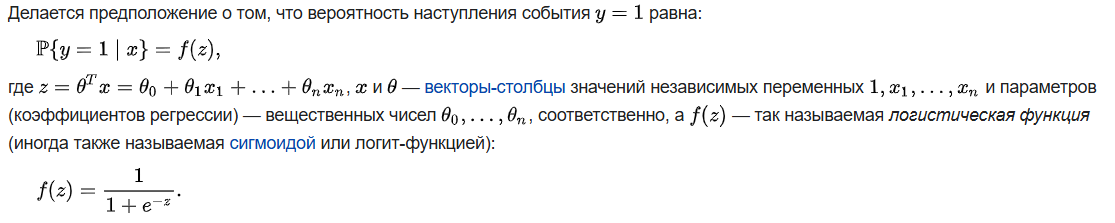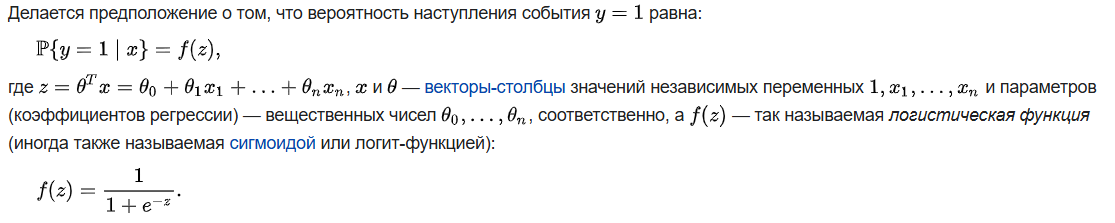

In [80]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        n_samples, n_features = X_array.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for iteration in range(self.n_iter):
            linear_model = np.dot(X_array, self.weights) + self.bias
            predictions = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X_array.T, (predictions - y_array))
            db = (1 / n_samples) * np.sum(predictions - y_array)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict_proba(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        linear_model = np.dot(X_array, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return np.column_stack([1 - probabilities, probabilities])
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= threshold).astype(int)

Подбор порога классификации по максимуму F1 на валидационной выборке
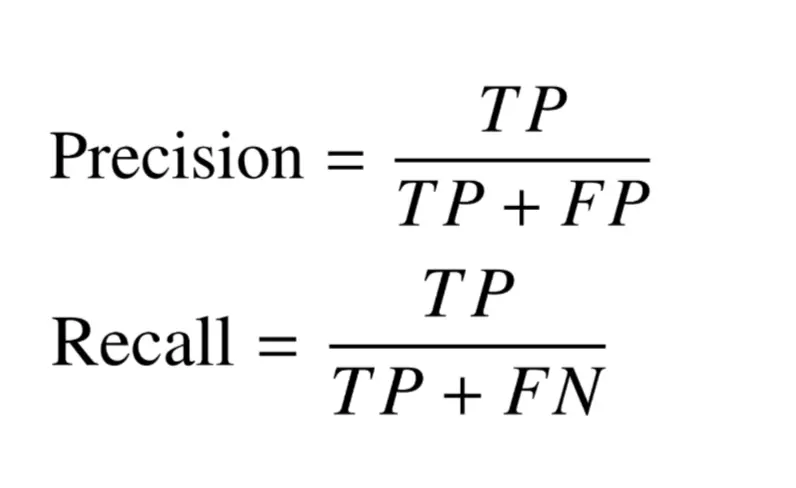

Optimal threshold: 0.5082 (F1-score: 0.9091)


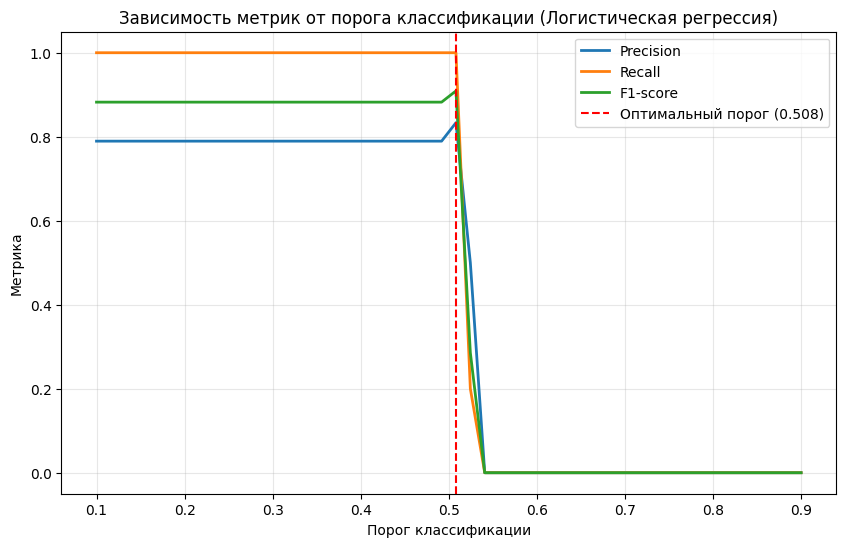

In [81]:
X_train_lr = X_train.values.astype(float)
X_val_lr = X_val.values.astype(float)
X_test_lr = X_test.values.astype(float)

lr_model = LogisticRegression(learning_rate=0.00000005, n_iter=100000)
lr_model.fit(X_train_lr, y_train)
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

y_val_proba = lr_model.predict_proba(X_val_lr)[:, 1]

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)
    
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print(f"Optimal threshold: {best_threshold:.4f} (F1-score: {best_f1:.4f})")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Оптимальный порог ({best_threshold:.3f})')
plt.xlabel('Порог классификации')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога классификации (Логистическая регрессия)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Оценка качества
Функции для вывода метрик и матриц неточностей

In [82]:
def evaluate_model(model, X, y, model_name, threshold=0.5):
    try:
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_array)
            
            if isinstance(y_pred_proba, list):
                y_pred_proba_array = np.array([p.get(1, 0) for p in y_pred_proba])
                y_pred = model.predict(X_array)
            else:
                y_pred_proba_array = y_pred_proba[:, 1]
                y_pred = (y_pred_proba_array >= threshold).astype(int)
            
            roc_auc = roc_auc_score(y_array, y_pred_proba_array)
        else:
            y_pred = model.predict(X_array)
            y_pred_proba_array = y_pred.astype(float)
            roc_auc = roc_auc_score(y_array, y_pred_proba_array)
        
        accuracy = accuracy_score(y_array, y_pred)
        precision = precision_score(y_array, y_pred, zero_division=0)
        recall = recall_score(y_array, y_pred, zero_division=0)
        
        print(f"\n{model_name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        
        cm = confusion_matrix(y_array, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Математика', 'Программирование'], 
                   yticklabels=['Математика', 'Программирование'])
        plt.title(f'Матрица ошибок - {model_name}')
        plt.ylabel('Истинные значения')
        plt.xlabel('Предсказанные значения')
        plt.show()
        
        return accuracy, precision, recall, roc_auc
    
    except Exception as e:
        print(f"Ошибка при оценке модели {model_name}: {e}")
        return 0, 0, 0, 0




Тривиальный классификатор:
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
ROC-AUC: 0.5000


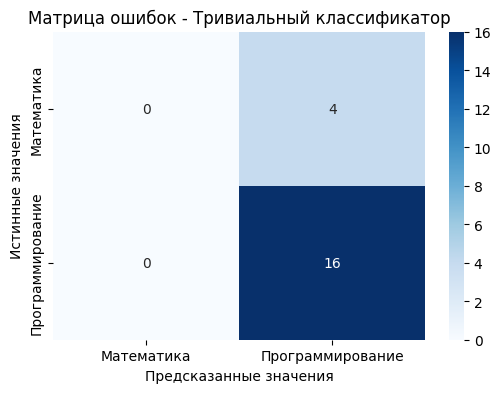


Наивный Байес:
Accuracy: 0.7000
Precision: 0.7778
Recall: 0.8750
ROC-AUC: 0.1562


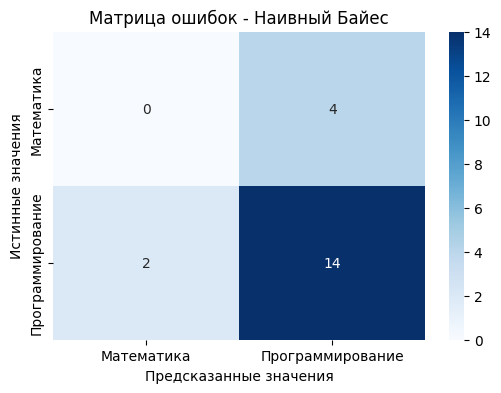


KNN (k=13):
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
ROC-AUC: 0.4766


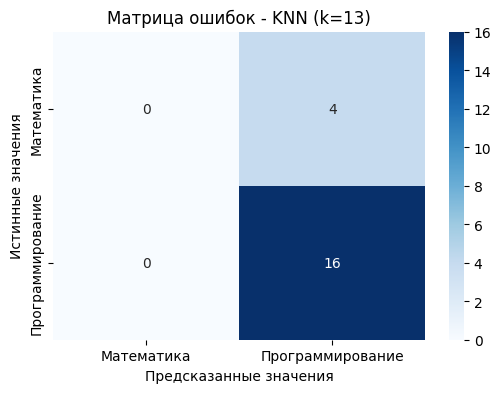


Логистическая регрессия:
Accuracy: 0.8000
Precision: 0.8000
Recall: 1.0000
ROC-AUC: 0.5000


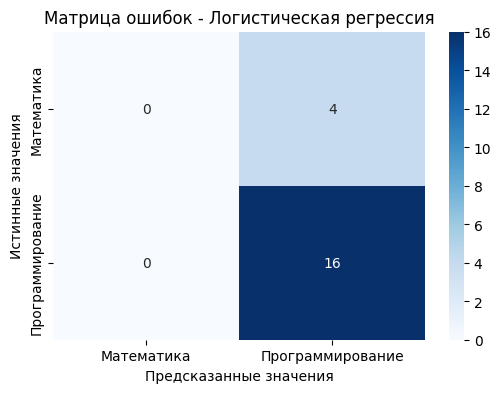

(0.8, 0.8, 1.0, 0.5)

In [67]:
evaluate_model(trivial_model, X_test, y_test, "Тривиальный классификатор")
evaluate_model(nb_model, X_test, y_test, "Наивный Байес")
evaluate_model(knn_model, X_test, y_test, f"KNN (k={best_k})")
evaluate_model(lr_model, X_test_lr, y_test, "Логистическая регрессия")

Исходя из этого можно сделать вывод, что на имеющихся данных тривиальный классификатор показал себя не хуже остальных. 
Произошло это только из-за того, что значений одного класса сильно больше значений другого класса.
KNN и Модель Логистической регрессии показали такую же accuracy (0.8), Наивный байесовский классификатор показал чуть меньшую точность.